# Apple Quality Classification Model

### Loading Libraries

In [1]:
import time
import tensorflow as tf
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from xgboost import XGBClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score,\
    f1_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from keras_tuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
# from ydatasynthetic import streamlit_app
# from ydata_synthetic.synthesizers.regular import RegularSynthesizer
# from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Project Goals:
Our objective is to develop an apple-quality binary classification model that is both robust and scalable, surpassing the baseline accuracy set by Nukman Hakim’s SVM (91% accuracy). We plan to do it in two ways: 
- Nukman opted not to remove outliers from the data but instead utilized RobustScaler to scale the data based on the interquartile range (IQR). In our analysis, we seek to contrast the performance of models trained using two distinct outlier-handling methods and evaluate the impact of outliers on accuracy. To achieve this, we plan to reuse Nukman’s code and retrain three of his models—Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN)—using both the original data containing outliers scaled with RobustScaler and data without outliers. Through this comparison, we aim to gain insights into how different outlier treatment methods affect the performance of models.
- Additionally, we will add three more models - AdaBoost, Logistic Regression, and ANN - to give us a wider range of options and hopefully discover a model that has a better performance than the SVM baseline.


# Exploratory Data Analysis

### Loading the data

In [2]:
# Load the file into a DataFrame
#apple_quality = pd.read_csv("apple_quality.csv")
apple_quality = pd.read_csv("/kaggle/input/apple-quality/apple_quality.csv")
display(apple_quality.head())

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [3]:
# Get the dimensions of the dataset
dimensions = apple_quality.shape
print("Number of rows:", dimensions[0])
print("Number of columns:", dimensions[1])

Number of rows: 4001
Number of columns: 9


In [4]:
#explore the data info
print(apple_quality.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB
None


The Apple quality dataset contains 4001 rows and 9 features. There are 8 numerical (continuous) features; A_id, Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, and Acidity. The dataset also has the categorical feature Quality, which is either ‘good’ or ‘bad’. All features are of type float except Acidity which is set as an object but contains numerical data and is later changed to type float. All the data from this dataset is already standardized from Kaggle. The Kaggle usability rating is 10, and we plan to use all features in all models. Nukman’s model is the Kaggle notebook with the highest rating.

### Dropping NaN

In [5]:
print(apple_quality.isnull().sum())

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64


In [6]:
apple_quality_cleaned = apple_quality.dropna()

print(apple_quality_cleaned.isnull().sum())

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64


### Re-labeling label classes

In [7]:
# Label encoding: 1 = good, 0 = bad
label_mapping = {"good": 1, "bad": 0}
apple_quality_cleaned = apple_quality_cleaned.copy()
apple_quality_cleaned['Quality'] = apple_quality_cleaned['Quality'].replace(label_mapping)

In [8]:
apple_quality_cleaned.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,1
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,1
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,0
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,1
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,1


### Fixing data type of a feature

In [9]:
# Check column data types
column_data_types = apple_quality_cleaned.dtypes
print(column_data_types)

A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality          int64
dtype: object


### Change Acidity data type from object to float

In [10]:
# Change 'Acidity' data type to float64
apple_quality_cleaned['Acidity'] = apple_quality_cleaned['Acidity'].astype('float64')
print(apple_quality_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 312.5 KB
None


In [11]:
apple_quality_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
A_id,4000.0,1999.500000,1154.844867,0.000000,999.750000,1999.500000,2999.250000,3999.000000
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736
Quality,4000.0,0.501000,0.500062,0.000000,0.000000,1.000000,1.000000,1.000000


### Dropping A_id because it does not add any value

In [12]:
#The feature A_id adds no value to the model and can be dropped
apple_quality_cleaned.drop("A_id", axis=1, inplace=True)

# Data Visualization

## Visualize probability distributions of variables

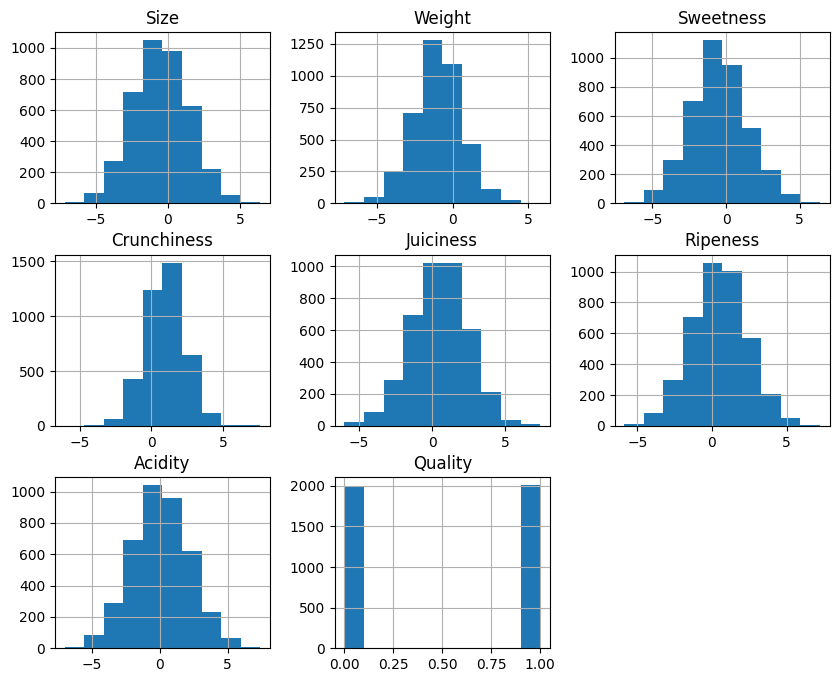

In [13]:
apple_quality_cleaned.hist(figsize=(10, 8))
plt.show()

All variables are almost perfectly bell shaped. No evident skeweness is present, indicating that the data might have been already scaled

### Visualize class label balance

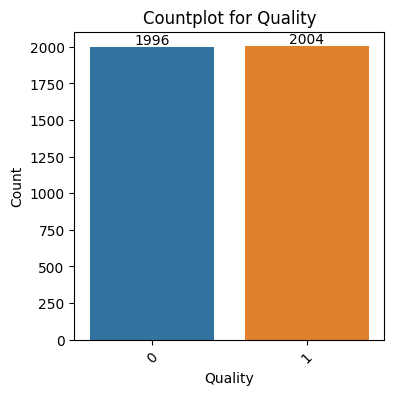

In [14]:
# Create count plot
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=apple_quality_cleaned, x='Quality')

# Set plot title and labels
plt.title('Countplot for Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Display the plot
plt.show()

The class labels shows a slight imbalance towards the negative class. Overall the dataset is well balanced

## Correlation Heat Map

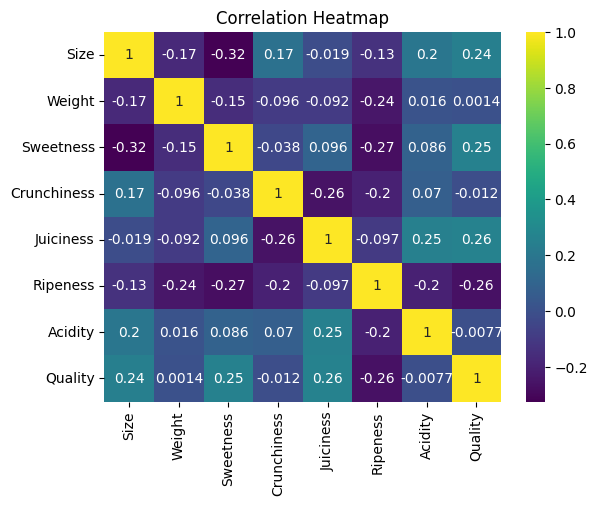

In [15]:
# Correlation Heatmap
corr_matrix = apple_quality_cleaned.corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

Most variables show a low correlation. Sweetness and Size show a moderate negative correlation of -0.32 

## Scatterplot Pair Plot

In [16]:
# # Pairplot
# plt.figure(figsize=(4, 4))
# sns.pairplot(apple_quality_cleaned, hue='Quality')
# plt.show()

# Data Pre-processing Workflow
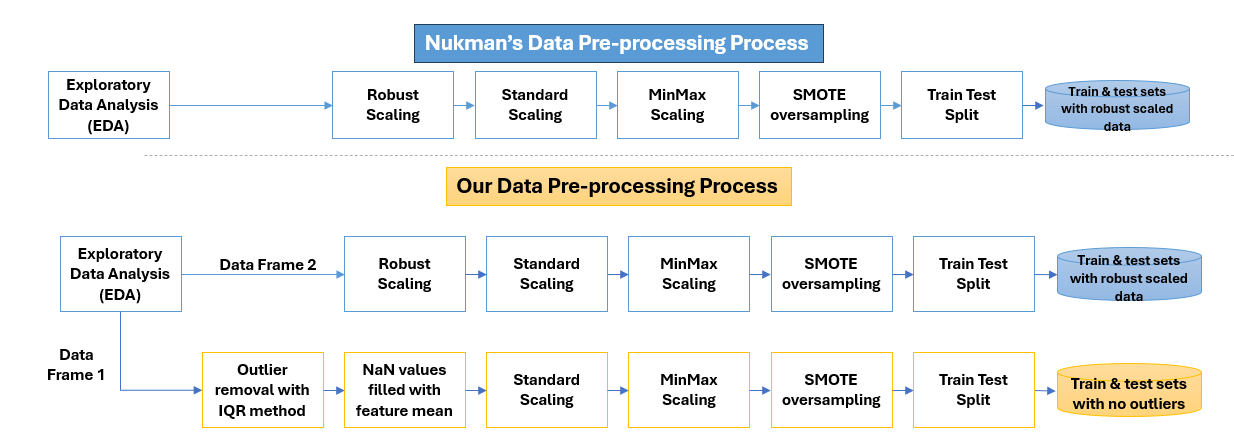

## Explore data to see if the features have outliers 

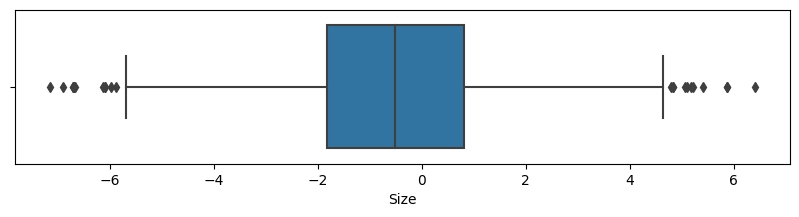

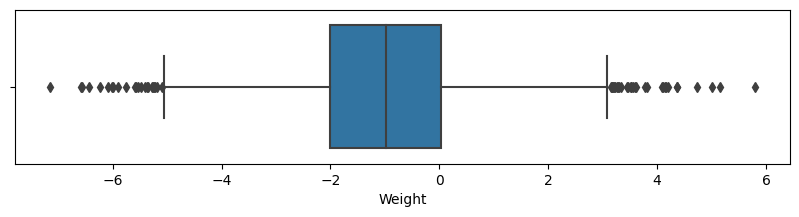

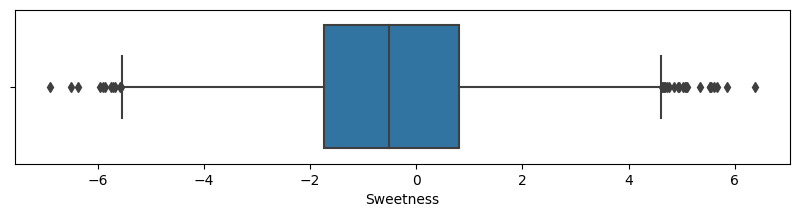

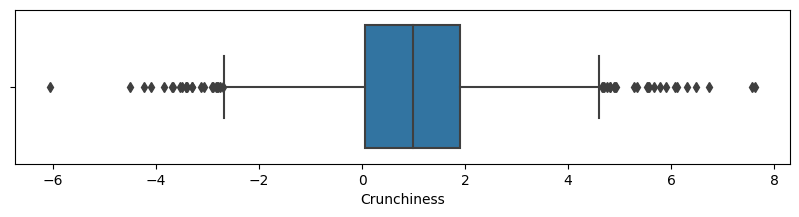

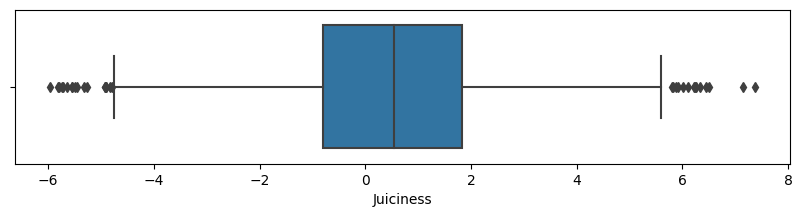

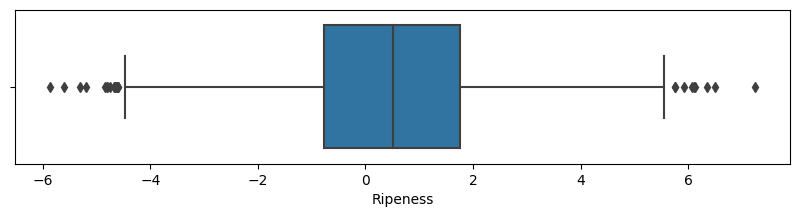

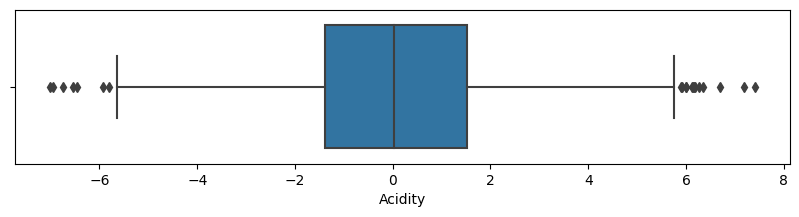

In [17]:
# Boxplot
for column in apple_quality_cleaned.columns:
    if column == 'Quality':
        break
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=column, data=apple_quality_cleaned)
    plt.show()

As we can see, all features have some outliers, but the number does not seem to be extremely high

# Outlier removal With IQR Method and Scaling

In [18]:
apple_quality_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Quality      4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


## Robust Scaler: 
RobustScaler scales the data by subtracting the median and then dividing by the interquartile range (IQR) of each feature.
This scaling method helps to center the data around the median and scale it to a range that is less sensitive to the presence of outliers.
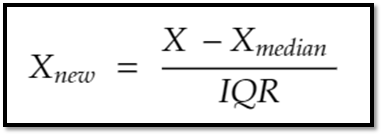


In [19]:
# Scaling with robust scaler
robust_scaler = RobustScaler()
numerical_features = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness','Acidity']
#Duplicate apple_quality_cleaned dataframe, this dataframe will be used to remove outliers
apple_quality_cleaned_no_out = apple_quality_cleaned.copy()
#apply robust scaler to original dataframe. This dataframe will be used to store the data scaled with robust scaler
apple_quality_cleaned[numerical_features] = robust_scaler.fit_transform(apple_quality_cleaned[numerical_features])

In [20]:
#create dataframe that will store the apple quality data with no outliers
apple_quality_no_outliers = pd.DataFrame()

outlier_count_arr = np.array([])

#This for loop removes the data points that fall above or below the 1.5*IQR values
for i in apple_quality_cleaned_no_out.columns:
    Q1 = apple_quality_cleaned_no_out[i].quantile(0.25)
    Q3 = apple_quality_cleaned_no_out[i].quantile(0.75)
    # Calculate the bounds for the current column
    lower_bound = Q1 - 1.5 * (Q3 - Q1)
    upper_bound = Q3 + 1.5 * (Q3 - Q1)
    # Filter out rows within the IQR range for the current column
    filtered_data = apple_quality_cleaned_no_out[(apple_quality_cleaned_no_out[i] >= lower_bound) & (apple_quality_cleaned_no_out[i] <= upper_bound)]
    #add outlier count to array
    outl_count = apple_quality_cleaned_no_out[i].shape[0] - len(filtered_data)
    outlier_count_arr = np.append(outlier_count_arr, outl_count)
    # Assign filtered data to the new DataFrame
    apple_quality_no_outliers[i] = filtered_data[i]

## Visualize outlier count

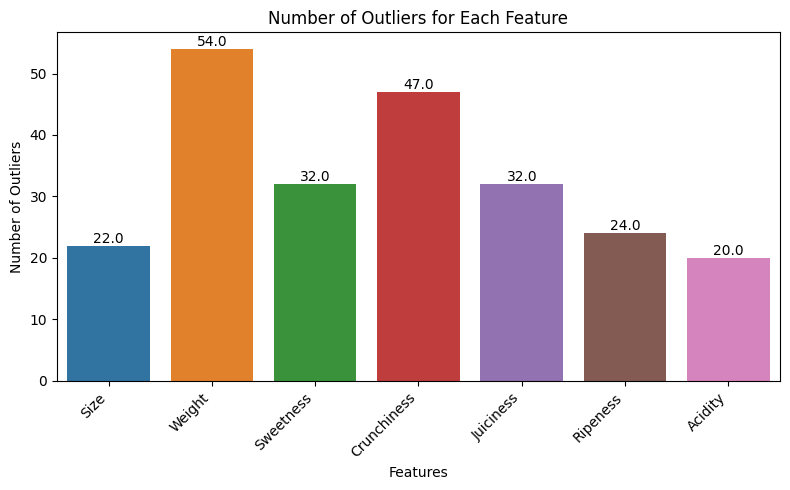

In [21]:

# Display the number of outliers for each feature
outl_count_df = pd.DataFrame(outlier_count_arr.reshape(1, 8), columns=apple_quality_cleaned.columns).T
outl_count_df.rename(columns={0: "# of outl"}, inplace=True)

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=outl_count_df.index[:-1], y=outl_count_df["# of outl"][:-1])

# Add the bar values
for index, value in enumerate(outl_count_df["# of outl"][:-1]):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers for Each Feature')
plt.tight_layout()
plt.show()

# Display the DataFrame
# display(outl_count_df.iloc[:-1,])

Weight and Crunchiness exhibit the highest number of outliers

## Box Plot with Outliers Removed

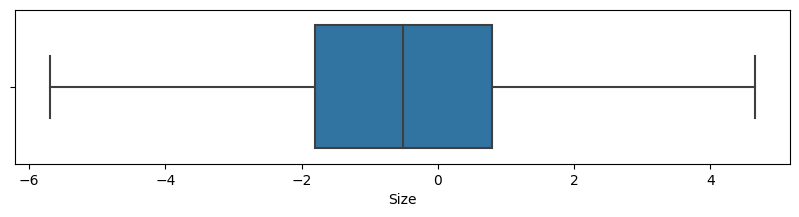

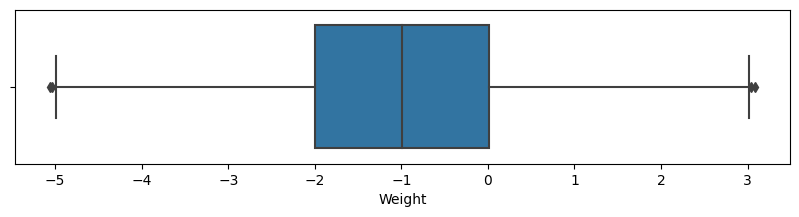

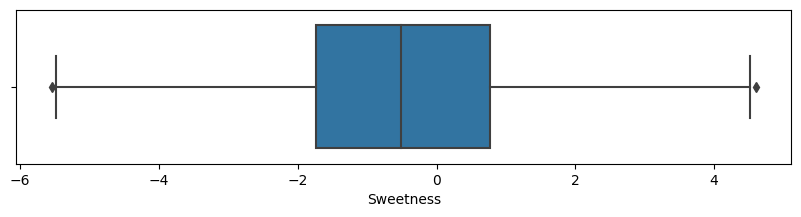

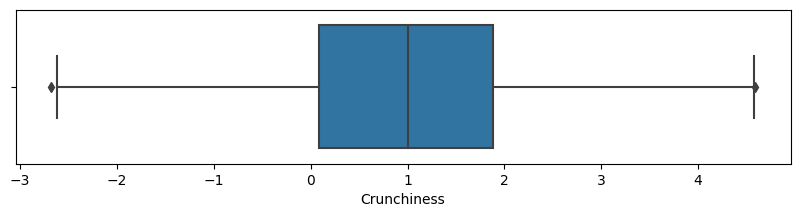

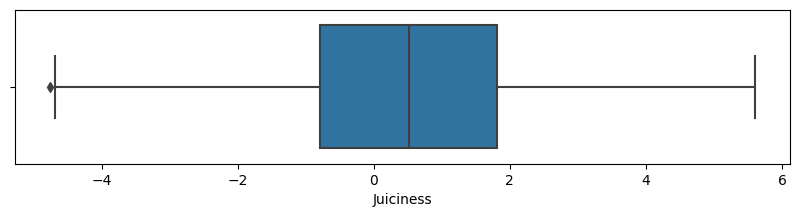

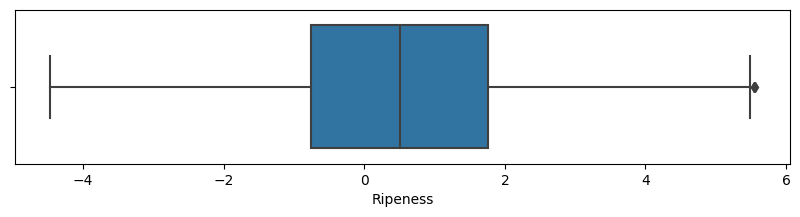

In [22]:
for column in apple_quality_no_outliers.iloc[:,:6].columns:
    plt.figure(figsize=(10, 2))
    sns.boxplot(data=apple_quality_no_outliers, x=column)
    plt.show()

## Apply standard scaling

In [23]:
# this happens after outlier removal however 
scaler = StandardScaler()

apple_quality_cleaned[numerical_features] = scaler.fit_transform(apple_quality_cleaned[numerical_features])
apple_quality_no_outliers[numerical_features] = scaler.fit_transform(apple_quality_no_outliers[numerical_features])

## Filling NaN Values

In [24]:
#Fill NaN
apple_quality_no_outliers.fillna(apple_quality_no_outliers.mean(), inplace=True)
apple_quality_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3978 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         3978 non-null   float64
 1   Weight       3978 non-null   float64
 2   Sweetness    3978 non-null   float64
 3   Crunchiness  3978 non-null   float64
 4   Juiciness    3978 non-null   float64
 5   Ripeness     3978 non-null   float64
 6   Acidity      3978 non-null   float64
 7   Quality      3978 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 279.7 KB


# Model preparation

## Scaling and resampling of data prviously scaled with Robust Scaler

In [25]:
# no outliers 
X_clean = apple_quality_no_outliers.drop("Quality", axis=1)
y_clean = apple_quality_no_outliers["Quality"]
display(X_clean.tail())
display(y_clean.tail())

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
3995,0.298571,-0.044310,-1.715315,-0.389427,0.637727,0.954013,0.035165
3996,0.111319,1.953263,0.149770,-1.235578,-0.260547,-0.872609,0.868166
3997,-1.132436,-0.753397,-1.038414,-0.249443,0.907039,2.335405,-0.679395
3998,-1.862036,-0.515735,1.515389,-0.901247,0.886495,-0.158623,-1.113795
3999,0.414985,-0.473466,0.322563,-1.626164,0.406211,-0.701935,0.744686


3995    0
3996    1
3997    0
3998    1
3999    1
Name: Quality, dtype: int64

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_clean = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled_clean, y_resampled_clean = smote.fit_resample(X_clean, y_clean)

## Scaling and resampling of data with outliers

In [27]:
# original data
X = apple_quality_cleaned.drop("Quality", axis=1)
y = apple_quality_cleaned["Quality"]
display(X.tail())
display(y.tail())

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
3995,0.291729,-0.048594,-1.669449,-0.365345,0.614425,0.931482,0.028866
3996,0.108878,1.834105,0.137124,-1.159058,-0.252634,-0.846326,0.842347
3997,-1.105655,-0.716904,-1.013784,-0.234036,0.874379,2.275957,-0.668950
3998,-1.818112,-0.492908,1.459901,-0.845446,0.854549,-0.151419,-1.093171
3999,0.405409,-0.453071,0.304496,-1.525439,0.390954,-0.680212,0.721761


3995    0
3996    1
3997    0
3998    1
3999    1
Name: Quality, dtype: int64

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

## Train Test Split Data

This code will create the train set and test set for the data without outliers

In [29]:
# no outliers 
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_resampled_clean, y_resampled_clean, test_size=0.2, random_state=42)

This code will create the train set and test set for the data scaled with Robust scaler

In [30]:
#original data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Custom Functions

In [31]:
#This functions automates the calculation of the F1, Precision, Recall and Accuracy scores
def test_model(y_test, y_pred, model_name=None):
    
    #if the model_name is ANN, then convert probability to binary label using a step function with threshold 0.5
    if model_name == "NN":
        y_pred = [1 if i >=0.5 else 0 for i in y_pred]
    
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    print("\nAccuracy:", accuracy)

    # Additional evaluation metrics
    print("\nClassification Report:")
    results = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T
    display(results)

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return results, accuracy

In [32]:
#ROC-AUC calculation and plotting
def ROC_AUC(y_pred_nn, y_test):
    roc_auc = roc_auc_score(y_test, y_pred_nn)

    print("ROC AUC:", roc_auc) 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Model Training

# <font color="red">Nukman's Models</font>

### <font color="red">SVM,trained with data scaled with Robust Scaler</font>

In [33]:
#From Kaggle Notebook**
SVM_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svc = SVC()

randomized_search = RandomizedSearchCV(svc, param_distributions=SVM_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_SVM_params = randomized_search.best_params_
print(f"Best Hyperparameters: {best_SVM_params}")

best_svc_model = randomized_search.best_estimator_
y_pred_SVM = best_svc_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


### <font color="red">performance metrics</font>

In [34]:
SVM_results, SVM_accuracy = test_model(y_test, y_pred_SVM)


Accuracy: 0.9152119700748129

Classification Report:


,precision,recall,f1-score,support
0,0.902500,0.925641,0.913924,390.000000
1,0.927861,0.905340,0.916462,412.000000
accuracy,0.915212,0.915212,0.915212,0.915212
macro avg,0.915180,0.915490,0.915193,802.000000
weighted avg,0.915528,0.915212,0.915228,802.000000



Confusion Matrix:
[[361  29]
 [ 39 373]]


### the accuracy of the SVM model matches the accuracy measured by Hakim; which ensures that the comparison is fair

### <font color="red">SVM, trained on data without outliers</font>

In [35]:
#From Kaggle Notebook**
SVM_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svc = SVC()

randomized_search_clean = RandomizedSearchCV(svc, param_distributions=SVM_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search_clean.fit(X_train_clean, y_train_clean)

best_SVM_params_clean = randomized_search_clean.best_params_
print(f"Best Hyperparameters: {best_SVM_params_clean}")

best_svc_model_clean = randomized_search_clean.best_estimator_
y_pred_SVM_clean = best_svc_model_clean.predict(X_test_clean)

Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


### <font color="red">performance metrics</font>

In [36]:
SVM_results_no_outl, SVM_accuracy_no_outl = test_model(y_test_clean, y_pred_SVM_clean)


Accuracy: 0.8858218318695107

Classification Report:


,precision,recall,f1-score,support
0,0.872038,0.908642,0.889964,405.000000
1,0.901333,0.862245,0.881356,392.000000
accuracy,0.885822,0.885822,0.885822,0.885822
macro avg,0.886686,0.885443,0.885660,797.000000
weighted avg,0.886447,0.885822,0.885730,797.000000



Confusion Matrix:
[[368  37]
 [ 54 338]]


### <font color="red">Random Forest, trained on data scaled without outliers</font>

In [37]:
#From Kaggle Notebook**
RF_normal_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

RF_normal = RandomForestClassifier()

randomized_search_RF = RandomizedSearchCV(
    RF_normal,
    param_distributions=RF_normal_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_RF.fit(X_train_clean, y_train_clean)

best_RF_params_clean = randomized_search_RF.best_params_
print(f"Best Hyperparameters for Random Forest: {best_RF_params_clean}")

best_RF_model = randomized_search_RF.best_estimator_

y_pred_RF_clean = best_RF_model.predict(X_test_clean)

Best Hyperparameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}


### <font color="red">performance metrics</font>

In [38]:
RF_results_no_outl, RF_accuracy_no_outl = test_model(y_test_clean, y_pred_RF_clean)


Accuracy: 0.875784190715182

Classification Report:


,precision,recall,f1-score,support
0,0.882500,0.871605,0.877019,405.000000
1,0.869018,0.880102,0.874525,392.000000
accuracy,0.875784,0.875784,0.875784,0.875784
macro avg,0.875759,0.875853,0.875772,797.000000
weighted avg,0.875869,0.875784,0.875792,797.000000



Confusion Matrix:
[[353  52]
 [ 47 345]]


### <font color="red">Random Forest, trained with data scaled with Robust Scaler</font>

In [39]:
#From Kaggle Notebook**
RF_normal_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

RF_normal = RandomForestClassifier()

randomized_search_RF = RandomizedSearchCV(
    RF_normal,
    param_distributions=RF_normal_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_RF.fit(X_train, y_train)

best_RF_params = randomized_search_RF.best_params_
print(f"Best Hyperparameters for Random Forest: {best_RF_params}")

best_RF_model = randomized_search_RF.best_estimator_

y_pred_RF = best_RF_model.predict(X_test)
svc_acc_score = accuracy_score(y_test, y_pred_RF)

Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}


## <font color="red">performance metrics</font>

In [40]:
RF_results, RF_accuracy = test_model(y_test, y_pred_RF)


Accuracy: 0.8902743142144638

Classification Report:


,precision,recall,f1-score,support
0,0.887179,0.887179,0.887179,390.000000
1,0.893204,0.893204,0.893204,412.000000
accuracy,0.890274,0.890274,0.890274,0.890274
macro avg,0.890192,0.890192,0.890192,802.000000
weighted avg,0.890274,0.890274,0.890274,802.000000



Confusion Matrix:
[[346  44]
 [ 44 368]]


## <font color="red">KNN trained on data without outliers</font>

In [41]:
#From Kaggle Notebook**
# Define a grid of hyperparameters to search
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2],
}

knn = KNeighborsClassifier()

randomized_search_knn_clean = RandomizedSearchCV(
    knn,
    param_distributions=knn_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn_clean.fit(X_train_clean, y_train_clean)

best_KNN_params_clean = randomized_search_knn_clean.best_params_
print(f"Best Hyperparameters for KNeighborsClassifier: {best_KNN_params_clean}")

best_knn_model_clean = randomized_search_knn_clean.best_estimator_

y_pred_KNN_clean = best_knn_model_clean.predict(X_test_clean)

Best Hyperparameters for KNeighborsClassifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 10, 'leaf_size': 10, 'algorithm': 'ball_tree'}


## <font color="red">performance metrics</font>

In [42]:
KNN_results_no_outl, KNN_accuracy_no_outl = test_model(y_test_clean, y_pred_KNN_clean)


Accuracy: 0.875784190715182

Classification Report:


,precision,recall,f1-score,support
0,0.873171,0.883951,0.878528,405.000000
1,0.878553,0.867347,0.872914,392.000000
accuracy,0.875784,0.875784,0.875784,0.875784
macro avg,0.875862,0.875649,0.875721,797.000000
weighted avg,0.875818,0.875784,0.875767,797.000000



Confusion Matrix:
[[358  47]
 [ 52 340]]


## <font color="red">KNN trained on data scaled with Robust Scaler</font>

In [43]:
#From Kaggle Notebook**
# Define a grid of hyperparameters to search
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2],
}

knn = KNeighborsClassifier()

randomized_search_knn = RandomizedSearchCV(
    knn,
    param_distributions=knn_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn.fit(X_train, y_train)

best_KNN_params = randomized_search_knn.best_params_
print(f"Best Hyperparameters for KNeighborsClassifier: {best_KNN_params}")

best_knn_model = randomized_search_knn.best_estimator_

y_pred_KNN = best_knn_model.predict(X_test)

Best Hyperparameters for KNeighborsClassifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'kd_tree'}


## <font color="red">performance metrics</font>

In [44]:
KNN_results, KNN_accuracy = test_model(y_test, y_pred_KNN)


Accuracy: 0.8890274314214464

Classification Report:


,precision,recall,f1-score,support
0,0.881013,0.892308,0.886624,390.000000
1,0.896806,0.885922,0.891331,412.000000
accuracy,0.889027,0.889027,0.889027,0.889027
macro avg,0.888909,0.889115,0.888978,802.000000
weighted avg,0.889126,0.889027,0.889042,802.000000



Confusion Matrix:
[[348  42]
 [ 47 365]]


# <font color="green">Our Models</font>

We chose to add three additional models: 
- Logistic Regression : was selected for its simplicity and capacity to offer probabilistic predictions in classification tasks
- AdaBoost was chosen for its ensemble learning technique, which leverages multiple weak classifiers to construct a robust learner
- The Artificial Neural Network (ANN) was preferred due to its adaptability and capability to discern complex patterns in data via deep learning, rendering it well-suited for highly nonlinear and high-dimensional classification tasks where conventional methods may struggle to achieve effective generalization. 

## <font color="green">Neural Network, trained on data scaled with Robust Scaler</font>

Talking Points
- Neural network model architecture defined using Keras Sequential API.
- The model consists of multiple dense layers with ReLU activation and dropout regularization.
- Dropout layers with a dropout rate of 0.5 are used to prevent overfitting.
- The output layer has a single neuron with sigmoid activation for binary classification.
- Model compiled with the Adam optimizer and binary cross-entropy loss.
- Training data fit to the model with a batch size of 16 and 100 epochs, with 20% of the training data used for validation.
- Training and validation loss curves plotted to visualize model performance during training.
- Model evaluated on both training and testing data to assess loss and accuracy.
- Finally, the model's predictions are evaluated using the `test_model` function, and the results are stored in `NN_results` and `NN_accuracy`.

In [45]:
# Define the neural network model
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_split=0.2)

Epoch 1/100
161/161 [==============================] - 5s 5ms/step - loss: 0.6952 - accuracy: 0.5023 - val_loss: 0.6887 - val_accuracy: 0.5888
Epoch 2/100
161/161 [==============================] - 1s 4ms/step - loss: 0.6888 - accuracy: 0.5351 - val_loss: 0.6826 - val_accuracy: 0.5919
Epoch 3/100
161/161 [==============================] - 1s 4ms/step - loss: 0.6722 - accuracy: 0.6002 - val_loss: 0.6426 - val_accuracy: 0.6760
Epoch 4/100
161/161 [==============================] - 1s 4ms/step - loss: 0.6300 - accuracy: 0.6607 - val_loss: 0.5656 - val_accuracy: 0.6978
Epoch 5/100
161/161 [==============================] - 1s 4ms/step - loss: 0.6017 - accuracy: 0.6817 - val_loss: 0.5448 - val_accuracy: 0.7259
Epoch 6/100
161/161 [==============================] - 1s 4ms/step - loss: 0.5541 - accuracy: 0.7344 - val_loss: 0.4950 - val_accuracy: 0.7570
Epoch 7/100
161/161 [==============================] - 1s 4ms/step - loss: 0.5344 - accuracy: 0.7371 - val_loss: 0.4688 - val_accuracy: 0.7695

## <font color="green">performance metrics</font>

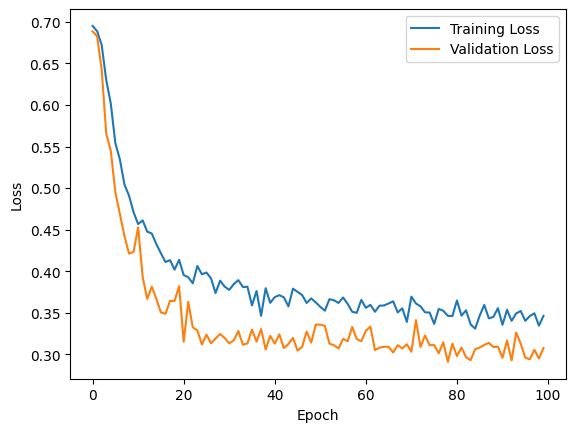

26/26 [==============================] - 0s 2ms/step - loss: 0.3056 - accuracy: 0.8865
Training Loss: 0.28510215878486633
Training Accuracy: 0.8658764958381653
Testing Loss: 0.3055591285228729
Testing Accuracy: 0.8865336775779724
26/26 [==============================] - 0s 1ms/step

Accuracy: 0.8865336658354115

Classification Report:


,precision,recall,f1-score,support
0,0.907357,0.853846,0.879789,390.000000
1,0.868966,0.917476,0.892562,412.000000
accuracy,0.886534,0.886534,0.886534,0.886534
macro avg,0.888161,0.885661,0.886175,802.000000
weighted avg,0.887635,0.886534,0.886351,802.000000



Confusion Matrix:
[[333  57]
 [ 34 378]]


In [46]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the training and testing data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

# Evaluate the model on the testing data
y_pred_NN = model.predict(X_test)

NN_results, NN_accuracy = test_model(y_test, y_pred_NN, model_name="NN")

## <font color="green">ROC-AUC</font>

ROC AUC: 0.947504356484939


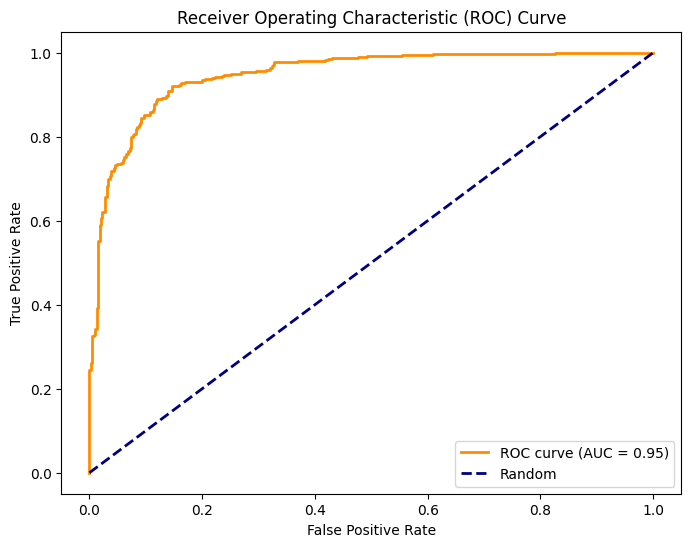

In [47]:
ROC_AUC(y_pred_NN, y_test)

## <font color="green">Neural Network, trained on data without outliers</font>

In [48]:
# Define the neural network model
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train_clean, y_train_clean, epochs=100, batch_size=16, verbose=1, validation_split=0.2)

Epoch 1/100
160/160 [==============================] - 3s 5ms/step - loss: 0.6946 - accuracy: 0.5224 - val_loss: 0.6223 - val_accuracy: 0.7551
Epoch 2/100
160/160 [==============================] - 1s 4ms/step - loss: 0.5962 - accuracy: 0.6845 - val_loss: 0.4696 - val_accuracy: 0.7739
Epoch 3/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4991 - accuracy: 0.7712 - val_loss: 0.3949 - val_accuracy: 0.8273
Epoch 4/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4628 - accuracy: 0.7951 - val_loss: 0.3799 - val_accuracy: 0.8210
Epoch 5/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4322 - accuracy: 0.8128 - val_loss: 0.3617 - val_accuracy: 0.8305
Epoch 6/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4127 - accuracy: 0.8238 - val_loss: 0.3511 - val_accuracy: 0.8273
Epoch 7/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4168 - accuracy: 0.8293 - val_loss: 0.3458 - val_accuracy: 0.8383

## <font color="green">performance metrics</font>

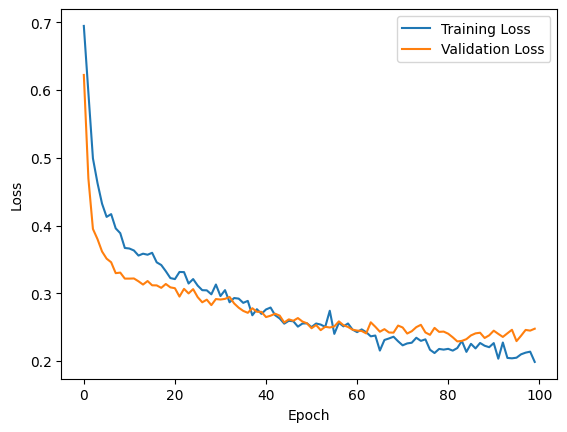

25/25 [==============================] - 0s 2ms/step - loss: 0.2304 - accuracy: 0.9184
Training Loss: 0.15286117792129517
Training Accuracy: 0.948194682598114
Testing Loss: 0.2304317206144333
Testing Accuracy: 0.9184441566467285
25/25 [==============================] - 0s 1ms/step

Accuracy: 0.918444165621079

Classification Report:


,precision,recall,f1-score,support
0,0.927136,0.911111,0.919054,405.000000
1,0.909774,0.926020,0.917826,392.000000
accuracy,0.918444,0.918444,0.918444,0.918444
macro avg,0.918455,0.918566,0.918440,797.000000
weighted avg,0.918597,0.918444,0.918450,797.000000



Confusion Matrix:
[[369  36]
 [ 29 363]]


In [49]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the training and testing data
train_loss, train_accuracy = model.evaluate(X_train_clean, y_train_clean)
test_loss, test_accuracy = model.evaluate(X_test_clean, y_test_clean)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

# Evaluate the model on the testing data
y_pred_NN_clean = model.predict(X_test_clean)

NN_results_no_outl, NN_accuracy_no_outl = test_model(y_test_clean, y_pred_NN_clean, model_name="NN")

## <font color="green">ROC-AUC</font>

ROC AUC: 0.9709309649785841


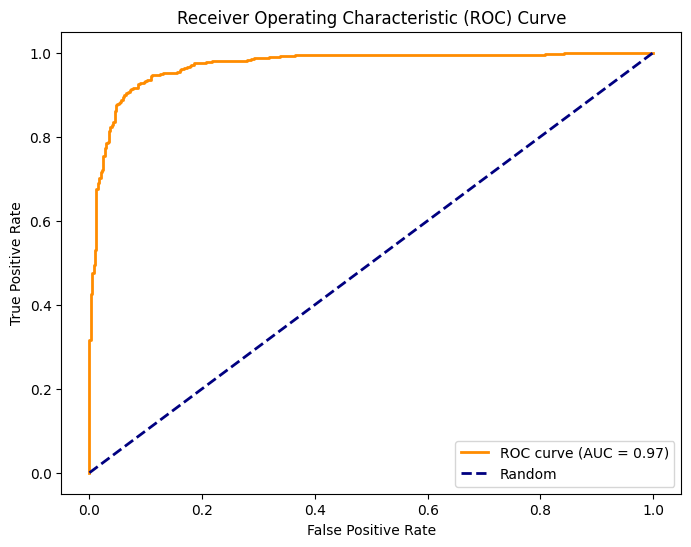

In [50]:
ROC_AUC(y_pred_NN_clean, y_test_clean)

## <font color="green">Logistic Regression, trained on data scaled with Robust Scaler</font>

Talking Points

- Pipeline combines feature scaling and logistic regression.
- Hyperparameters grid defined for logistic regression.
- Grid search with cross-validation for parameter tuning.
- Best model selected based on F1 score.
- Model's performance evaluated on test set.
- Best hyperparameters extracted for further analysis.

In [51]:
# using pipeline with feature scaling and lr
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling step
    ('log_reg', LogisticRegression())
])

# hyperparameters 
param_grid = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'log_reg__penalty': ['l1', 'l2'],               # Using L1 and L2 as penalties
    'log_reg__solver': ['liblinear', 'saga'],       # Solvers for logistic regression
    'log_reg__max_iter': [100, 200, 300],           # Maximum number of iterations
}

# gridsearch with cross validation
randomized_search_LR = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
randomized_search_LR.fit(X_train, y_train)

# best model using grid_search
best_model = randomized_search_LR.best_estimator_

best_LR_params = randomized_search_LR.best_params_
print(best_LR_params)

# look for best model
y_pred_LR = best_model.predict(X_test)

{'log_reg__solver': 'liblinear', 'log_reg__penalty': 'l1', 'log_reg__max_iter': 200, 'log_reg__C': 0.1}


## <font color="green">performance metrics</font>

In [52]:
#Get performance metrics
LR_results, LR_accuracy = test_model(y_test, y_pred_LR)


Accuracy: 0.7443890274314214

Classification Report:


,precision,recall,f1-score,support
0,0.730673,0.751282,0.740834,390.000000
1,0.758105,0.737864,0.747847,412.000000
accuracy,0.744389,0.744389,0.744389,0.744389
macro avg,0.744389,0.744573,0.744341,802.000000
weighted avg,0.744765,0.744389,0.744437,802.000000



Confusion Matrix:
[[293  97]
 [108 304]]


## <font color="green">Logistic Regression, trained on data without outliers</font>

In [53]:
# using pipeline with feature scaling and lr
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling step
    ('log_reg', LogisticRegression())
])

# hyperparameters 
LR_grid_clean = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'log_reg__penalty': ['l1', 'l2'],               # Using L1 and L2 as penalties
    'log_reg__solver': ['liblinear', 'saga'],       # Solvers for logistic regression
    'log_reg__max_iter': [100, 200, 300],           # Maximum number of iterations
}

randomized_search_LR_Clean = RandomizedSearchCV(pipeline, param_distributions=LR_grid_clean, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
randomized_search_LR_Clean.fit(X_train_clean, y_train_clean)

# best model using grid_search
best_model_clean = randomized_search_LR_Clean.best_estimator_

best_LR_params_clean = randomized_search_LR_Clean.best_params_
print(best_LR_params_clean)

# look for best model
y_pred_LR_clean = best_model_clean.predict(X_test_clean)
LR_accuracy_clean = accuracy_score(y_test_clean, y_pred_LR_clean)
LR_acc_score_clean = accuracy_score(y_test_clean, y_pred_LR_clean)

{'log_reg__solver': 'liblinear', 'log_reg__penalty': 'l2', 'log_reg__max_iter': 100, 'log_reg__C': 100}


## <font color="green">performance metrics</font>

In [54]:
LR_results_no_outl, LR_accuracy_no_outl = test_model(y_test_clean, y_pred_LR_clean)


Accuracy: 0.7302383939774153

Classification Report:


,precision,recall,f1-score,support
0,0.724057,0.758025,0.740651,405.000000
1,0.737265,0.701531,0.718954,392.000000
accuracy,0.730238,0.730238,0.730238,0.730238
macro avg,0.730661,0.729778,0.729803,797.000000
weighted avg,0.730553,0.730238,0.729980,797.000000



Confusion Matrix:
[[307  98]
 [117 275]]


## <font color="green">AdaBoost, trained on data without outliers</font>

Talking Points
- Hyperparameter grid defined for AdaBoost.
- Randomized search conducted to optimize hyperparameters.
- Cross-validation used for evaluation.
- Scoring metric set to accuracy.
- Best hyperparameters extracted.
- Best AdaBoost model obtained.
- Model evaluated on test data.
- Performance metrics calculated and stored.

In [55]:
Ada_param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5]
}

adaBoost_model_clean = AdaBoostClassifier()

randomized_search_clean = RandomizedSearchCV(adaBoost_model_clean, param_distributions=Ada_param_grid, n_iter=10,\
                                             cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search_clean.fit(X_train_clean, y_train_clean)

best_ADA_params_clean = randomized_search_clean.best_params_
print(f"Best Hyperparameters: {best_ADA_params_clean}")

best_ADA_model_clean = randomized_search_clean.best_estimator_
y_pred_ADA_clean = best_ADA_model_clean.predict(X_test_clean)

ADA_acc_score = accuracy_score(y_test_clean, y_pred_ADA_clean)

Best Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.5}


## <font color="green">performance metrics</font>

In [56]:
ADA_results_no_outl,ADA_accuracy_no_outl = test_model(y_test_clean, y_pred_ADA_clean)


Accuracy: 0.7553324968632371

Classification Report:


,precision,recall,f1-score,support
0,0.746479,0.785185,0.765343,405.000000
1,0.765499,0.724490,0.744430,392.000000
accuracy,0.755332,0.755332,0.755332,0.755332
macro avg,0.755989,0.754837,0.754886,797.000000
weighted avg,0.755834,0.755332,0.755057,797.000000



Confusion Matrix:
[[318  87]
 [108 284]]


## <font color="green">AdaBoost trained on data scaled with Robust Scaler</font>

In [57]:
Ada_param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5]
}

adaBoost_model = AdaBoostClassifier()

randomized_search = RandomizedSearchCV(adaBoost_model, param_distributions=Ada_param_grid, n_iter=10,\
                                       cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_ADA_params = randomized_search.best_params_
print(f"Best Hyperparameters: {best_ADA_params}")
best_ADA_model = randomized_search.best_estimator_
y_pred_ADA = best_ADA_model.predict(X_test)

Best Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.5}


## <font color="green">performance metrics</font>

In [58]:
ADA_results, ADA_accuracy = test_model(y_test, y_pred_ADA)


Accuracy: 0.7743142144638404

Classification Report:


,precision,recall,f1-score,support
0,0.753027,0.797436,0.774595,390.000000
1,0.796915,0.752427,0.774032,412.000000
accuracy,0.774314,0.774314,0.774314,0.774314
macro avg,0.774971,0.774932,0.774314,802.000000
weighted avg,0.775573,0.774314,0.774306,802.000000



Confusion Matrix:
[[311  79]
 [102 310]]


# <font color="blue">Results</font>

Merge all performance metric values from all models into a single dataframe

In [59]:
df_results_KNN = pd.DataFrame(pd.concat([KNN_results.iloc[-1, :], KNN_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_KNN.columns = ["KNN - Robust_scaled", "KNN - No Outl"]


df_results_SVM = pd.DataFrame(pd.concat([SVM_results.iloc[-1, :], SVM_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_SVM.columns = ["SVM - Robust_scaled", "SVM - No Outl"]


df_results_ADA = pd.DataFrame(pd.concat([ADA_results.iloc[-1, :], ADA_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_ADA.columns = ["ADA - Robust_scaled", "ADA - No Outl"]


df_results_RF = pd.DataFrame(pd.concat([RF_results.iloc[-1, :], RF_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_RF.columns = ["RF - Robust_scaled", "RF - No Outl"]


df_results_LR = pd.DataFrame(pd.concat([LR_results.iloc[-1, :], LR_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_LR.columns = ["LR - Robust_scaled", "LR - No Outl"]


df_results_NN = pd.DataFrame(pd.concat([NN_results.iloc[-1, :], NN_results_no_outl.iloc[-1, :]], axis=1))
# Set the column names
df_results_NN.columns = ["NN - Robust_scaled", "NN - No Outl"]


In [60]:
accuracy_array = np.array([SVM_accuracy, SVM_accuracy_no_outl,NN_accuracy, NN_accuracy_no_outl,KNN_accuracy, \
                           KNN_accuracy_no_outl,ADA_accuracy, ADA_accuracy_no_outl,RF_accuracy, RF_accuracy_no_outl,LR_accuracy, LR_accuracy_no_outl])
accuracy_array = accuracy_array.reshape(12,1)
# accuracy_array

## <font color="blue">Performance Metrics</font>
- Precision measures the proportion of correctly predicted positive instances among all instances predicted as positive, indicating the model's ability to avoid false positives. 
- Recall quantifies the proportion of correctly predicted positive instances among all actual positive instances, indicating the model's ability to capture all positive instances without missing any. 
- F1 combines precision and recall into a single metric, providing a harmonic mean that balances both metrics, useful for situations where precision and recall are both important and need to be considered simultaneously.
- Accuracy: calculates as the ratio of the number of correct predictions to the total number of predictions.
- The ROC (Receiver Operating Characteristic) curve is a graphical representation of the true positive rate against the false positive rate at various threshold settings. The AUC is the area under this curve, ranging from 0 to 1.

In [61]:
df_results_final = pd.concat([df_results_SVM, df_results_NN, df_results_KNN, df_results_ADA, df_results_RF, df_results_LR], axis=1)
df_results_final = df_results_final.iloc[:-1, :].T
df_results_final['Accuracy'] = accuracy_array
df_results_final

,precision,recall,f1-score,Accuracy
SVM - Robust_scaled,0.915528,0.915212,0.915228,0.915212
SVM - No Outl,0.886447,0.885822,0.885730,0.885822
NN - Robust_scaled,0.887635,0.886534,0.886351,0.886534
NN - No Outl,0.918597,0.918444,0.918450,0.918444
KNN - Robust_scaled,0.889126,0.889027,0.889042,0.889027
KNN - No Outl,0.875818,0.875784,0.875767,0.875784
ADA - Robust_scaled,0.775573,0.774314,0.774306,0.774314
ADA - No Outl,0.755834,0.755332,0.755057,0.755332
RF - Robust_scaled,0.890274,0.890274,0.890274,0.890274
RF - No Outl,0.875869,0.875784,0.875792,0.875784


## NN ROC-AUC

ROC AUC: 0.9709309649785841


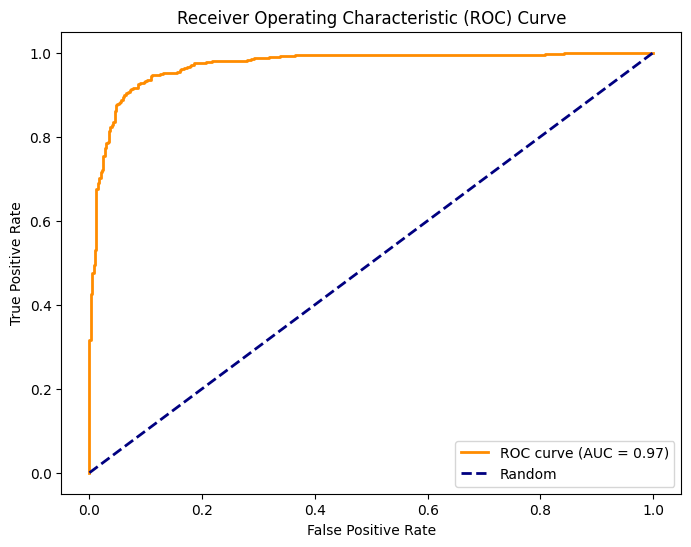

In [62]:
ROC_AUC(y_pred_NN_clean, y_test_clean)

## Final Remarks:
In conclusion, the NN has proven to be the best-performing model, with accuracy and F1 of 92% and 92% respectively, when trained on the dataset without outliers. The project successfully developed a binary classification model for apple quality that outperformed the accuracy set by Nukman Hakim’s SVM model on the dataset without outliers; with the Robust scaled dataset the performance of the NN and SVM is very close (88.6% Vs 91.5%). The comparison of different outlier-handling methods provided valuable insights into model performance, indicating the importance of robust preprocessing techniques in improving model generalization and performance metrics. Further analysis, including feature importance, scaling techniques, model interpretation, and hyperparameter tuning, could provide additional insights and improvements for continued enhancement of the model's predictive capabilities.
